In [25]:
def print_pixel_over_ROI(x,y,w,h,image_gray):
    
    # Iterate over each pixel in the image
    for row in range(y,y+h):
        for col in range(x,x+w):
            # Access the pixel value at the current position
            pixel = image_gray[row, col]

            # Print the pixel value
            print('Pixel at ({}, {}): {}'.format(row, col, pixel))
        

In [42]:
import cv2
import numpy as np
import os

def extract_middle_roi(image, target_width):
    # Get the original image dimensions
    height, width = image.shape[:2]

    # Calculate the aspect ratio
    aspect_ratio = width / height

    # Calculate the target height based on the aspect ratio
    target_height = int(target_width / aspect_ratio)

    # Calculate the coordinates of the top-left and bottom-right corners of the middle region
    x = int((width - target_width) / 2)
    y = int((height - target_height) / 2)
    x2 = x + target_width
    y2 = y + target_height

    # Extract the middle region
    middle_roi = image[y:y2, x:x2]

    return middle_roi

def filter_contours(contours, binary_image, ratio, ratio2=None):
    # Create a copy of the original image
    image_with_rectangles = np.copy(binary_image)
    
    #ratio is a list with first element as lower bound and second element as upper bound
    aspect_ratios = []
    filtered_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image_with_rectangles, (x, y), (x + w, y + h), (255), 1)  # Adjust color and thickness as needed
        
        aspect_ratio = float(w) / h
        if not ratio2:
            if aspect_ratio >= ratio[0] and aspect_ratio <= ratio[1]:
                filtered_contours.append(contour)
        else:
            if (aspect_ratio >= ratio[0] and aspect_ratio <= ratio[1]) or (aspect_ratio >= ratio2[0] and aspect_ratio <= ratio2[1]):
                filtered_contours.append(contour)
                
    #Check the images with bounding rectangles
    cv2.imwrite("bounding_rect.jpg", image_with_rectangles)
    
    # Create a mask of the filtered contours
    mask = np.zeros_like(binary_image)
    cv2.drawContours(mask, filtered_contours, -1, (255), thickness=cv2.FILLED)
    return mask

def preprocess_image(image_path, threshold_val=0):
    # Load the grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Crop image
    image = extract_middle_roi(image, 1500)

    if threshold_val == 0:
        threshold_val = 5
        # Find threshold with sd
        for x in range(5, 10):
            mask = np.where(image < x, 1, 0)
            masked_intensities = image[mask == 1]
            mean_intensity = np.mean(masked_intensities)
            sd_intensity = np.std(masked_intensities)
            two_sd = (mean_intensity + (2 * sd_intensity))
            three_sd = (mean_intensity + (3 * sd_intensity))
            print("current threshold: {}".format(x))
            print("two_sd: {}".format(two_sd))
            print("three_sd: {}".format(three_sd))

            if x >= two_sd and x <= three_sd:
                threshold_val = x

    # Filter out pixels with intensities below the threshold_val
    threshold_val, image_filtered = cv2.threshold(image, threshold_val, 255, cv2.THRESH_TOZERO)

    print("Threshold value:", threshold_val)

    # Save and download to local disk
    # Extract the filename from the original image path
    filename = image_path.split("/")[-1]

    # Create the new path by concatenating the desired directory and the filename
    new_path = os.path.dirname(image_path) + "/thresholded/"

    # Create the folder if it doesn't exist
    if not os.path.exists(new_path):
        os.makedirs(new_path)

    new_path += filename

    cv2.imwrite(new_path, image_filtered)

    print("Saved thresholded image to: {}".format(new_path))

    # Find contours in the image
    contours, _ = cv2.findContours(image_filtered, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Iterate over the contours and filter out ovals with a width-to-length ratio:
    red_ratio = [2, 10]
    blue_ratio = [1, 1.5]
    green_ratio = [1.5, 2]
    green_ratio_2 = [0, 1]
    ratio_map = {"red": red_ratio, "blue": blue_ratio, "green": green_ratio}

    for color_name, color_ratio in ratio_map.items():
        if color_name == "green":
            mask = filter_contours(contours, image_filtered, color_ratio, ratio2=green_ratio_2)
        else:
            mask = filter_contours(contours, image_filtered, color_ratio)

        # Apply the mask
        image_ratio_filtered = cv2.bitwise_and(image_filtered, image_filtered, mask=mask)

        # Save and download to local disk
        # Extract the filename from the original image path
        filename = image_path.split("/")[-1]

        # Create the new path by concatenating the desired directory and the filename
        new_path = os.path.dirname(image_path) + "/thresholded/" + color_name + "/"

        # Create the folder if it doesn't exist
        if not os.path.exists(new_path):
            os.makedirs(new_path)

        new_path += filename

        cv2.imwrite(new_path, image_ratio_filtered)

        print("Saved filtered {} image to: {}".format(color_name, new_path))

    return threshold_val


In [43]:
#test preprocessing
preprocess_image("/mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/4_8_8_clear_110000000.bmp")

current threshold: 5
two_sd: 4.256466784434245
three_sd: 4.394401379600533
current threshold: 6
two_sd: 5.640939215528086
three_sd: 6.097335857235081
current threshold: 7
two_sd: 6.696463197756097
three_sd: 7.413977716961054
current threshold: 8
two_sd: 7.608682632836092
three_sd: 8.577274269647877
current threshold: 9
two_sd: 8.45560187813587
three_sd: 9.674372360955237
Threshold value: 9.0
Saved thresholded image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/4_8_8_clear_110000000.bmp
Saved filtered red image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/red/4_8_8_clear_110000000.bmp
Saved filtered blue image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/blue/4_8_8_clear_110000000.bmp
Saved filtered green image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/green/4_8_8_clear_110000000.bmp


9.0

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_max_intensity_location(image_name):
    # Load the grayscale image
    image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)

    # Initialize variables to track the highest intensity and its location
    max_intensity = 0
    max_intensity_location = None

    # Iterate over each pixel in the image
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            intensity = image[x,y]

            # Update the highest intensity and its location if a higher intensity is found
            if intensity > max_intensity and intensity < 255:
                max_intensity = intensity
                max_intensity_location = (x,y)
    
    # Print the highest intensity pixel
    print("Highest intensity:", max_intensity)
    
    # Print the location of the highest intensity pixel
    print("Highest intensity location:", max_intensity_location)
    return max_intensity_location



In [29]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def rotate_image(image_path, angle):
    image = Image.open(image_path)
    # Rotate the image with bilinear interpolation
    rotated_image = image.rotate(angle, resample=Image.BILINEAR)
    return rotated_image

def plot_intensity_vs_x(image_name, x, fixed_y):
    # Load the grayscale image
    image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)

    # Initialize lists to store the x-axis coordinates and y-axis intensities
    x_coordinates = []
    intensities = []

    # Iterate over each pixel in the image
    for x in range(x - 40, x + 40):
        intensity = image[fixed_y, x]
        x_coordinates.append(x)
        intensities.append(intensity)
        if intensity > 225:
            with open(os.path.dirname(image_name) + 'logfile.txt', "a") as f:
                print("{} is overexposed.".format(image_name), file=f)

    # Plot the graph
    plt.scatter(x_coordinates, intensities)
    plt.xlabel('X Coordinates')
    plt.ylabel('Pixel Intensity')
    plt.title('Intensity vs X Coordinate')

    plot_path = os.path.dirname(image_name) + "/plots/"

    # Create the folder if it doesn't exist
    if not os.path.exists(plot_path):
        os.makedirs(plot_path)

    plt.savefig(os.path.dirname(image_name) + "/plots/" + os.path.basename(image_name) + "_vs_x.jpg")

    plt.show()

def plot_intensity_vs_y(image_name, fixed_x, y):
    # Load the grayscale image
    image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)

    # Initialize lists to store the x-axis coordinates and y-axis intensities
    y_coordinates = []
    intensities = []

    # Iterate over each pixel in the image
    for y in range(y - 40, y + 40):
        intensity = image[y, fixed_x]
        y_coordinates.append(y)
        intensities.append(intensity)
        if intensity > 225:
            with open(os.path.dirname(image_name) + 'logfile.txt', "a") as f:
                print("{} is overexposed.".format(image_name), file=f)

    # Plot the graph
    plt.scatter(y_coordinates, intensities)
    plt.xlabel('Y Coordinates')
    plt.ylabel('Pixel Intensity')
    plt.title('Intensity vs Y Coordinate')

    plot_path = os.path.dirname(image_name) + "/plots/"

    # Create the folder if it doesn't exist
    if not os.path.exists(plot_path):
        os.makedirs(plot_path)

    plt.savefig(os.path.dirname(image_name) + "/plots/" + os.path.basename(image_name) + "_vs_y.jpg")

    plt.show()


current threshold: 5
two_sd: 4.0
three_sd: 4.0
current threshold: 6
two_sd: 5.0935167351583175
three_sd: 5.141425367480949
current threshold: 7
two_sd: 6.60565304502131
three_sd: 7.011979593927337
current threshold: 8
two_sd: 7.713676361369956
three_sd: 8.384076420992898
current threshold: 9
two_sd: 8.678265474965439
three_sd: 9.603858590659351
Threshold value: 9.0
Saved thresholded image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/128_128_128_clear_200000.bmp
Saved filtered red image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/red/128_128_128_clear_200000.bmp
Saved filtered blue image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/blue/128_128_128_clear_200000.bmp
Saved filtered green image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/green/128_128_128_clear_200000.bmp
Threshold value: 9.0
Saved thresholded image to: /mnt/c/Users/alada/JC_Electronics/JC-S

Threshold value: 9.0
Saved thresholded image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/128_64_64_Z_1100000.bmp
Saved filtered red image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/red/128_64_64_Z_1100000.bmp
Saved filtered blue image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/blue/128_64_64_Z_1100000.bmp
Saved filtered green image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/green/128_64_64_Z_1100000.bmp
Threshold value: 9.0
Saved thresholded image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/128_8_128_clear_200000.bmp
Saved filtered red image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/red/128_8_128_clear_200000.bmp
Saved filtered blue image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/blue/128_8_128_clear_200000.bmp
Saved filtered green image to: /mn

Threshold value: 9.0
Saved thresholded image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/16_64_16_clear_23000000.bmp
Saved filtered red image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/red/16_64_16_clear_23000000.bmp
Saved filtered blue image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/blue/16_64_16_clear_23000000.bmp
Saved filtered green image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/green/16_64_16_clear_23000000.bmp
Threshold value: 9.0
Saved thresholded image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/16_64_16_Z_23000000.bmp
Saved filtered red image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/red/16_64_16_Z_23000000.bmp
Saved filtered blue image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/blue/16_64_16_Z_23000000.bmp
Saved filtered green image 

Threshold value: 9.0
Saved thresholded image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/32_16_32_Z_5600000.bmp
Saved filtered red image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/red/32_16_32_Z_5600000.bmp
Saved filtered blue image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/blue/32_16_32_Z_5600000.bmp
Saved filtered green image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/green/32_16_32_Z_5600000.bmp
Threshold value: 9.0
Saved thresholded image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/32_32_32_clear_5600000.bmp
Saved filtered red image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/red/32_32_32_clear_5600000.bmp
Saved filtered blue image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/blue/32_32_32_clear_5600000.bmp
Saved filtered green image to: /mnt/c/

Threshold value: 9.0
Saved thresholded image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/4_128_128_clear_200000.bmp
Saved filtered red image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/red/4_128_128_clear_200000.bmp
Saved filtered blue image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/blue/4_128_128_clear_200000.bmp
Saved filtered green image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/green/4_128_128_clear_200000.bmp
Threshold value: 9.0
Saved thresholded image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/4_128_128_Z_200000.bmp
Saved filtered red image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/red/4_128_128_Z_200000.bmp
Saved filtered blue image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/blue/4_128_128_Z_200000.bmp
Saved filtered green image to: /mn

Threshold value: 9.0
Saved thresholded image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/64_16_16_Z_23000000.bmp
Saved filtered red image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/red/64_16_16_Z_23000000.bmp
Saved filtered blue image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/blue/64_16_16_Z_23000000.bmp
Saved filtered green image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/green/64_16_16_Z_23000000.bmp
Threshold value: 9.0
Saved thresholded image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/64_16_64_clear_1100000.bmp
Saved filtered red image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/red/64_16_64_clear_1100000.bmp
Saved filtered blue image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/blue/64_16_64_clear_1100000.bmp
Saved filtered green image to: /mn

Threshold value: 9.0
Saved thresholded image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/8_128_128_clear_200000.bmp
Saved filtered red image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/red/8_128_128_clear_200000.bmp
Saved filtered blue image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/blue/8_128_128_clear_200000.bmp
Saved filtered green image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/green/8_128_128_clear_200000.bmp
Threshold value: 9.0
Saved thresholded image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/8_128_128_Z_200000.bmp
Saved filtered red image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/red/8_128_128_Z_200000.bmp
Saved filtered blue image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/blue/8_128_128_Z_200000.bmp
Saved filtered green image to: /mn

Threshold value: 9.0
Saved thresholded image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/8_64_8_clear_110000000.bmp
Saved filtered red image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/red/8_64_8_clear_110000000.bmp
Saved filtered blue image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/blue/8_64_8_clear_110000000.bmp
Saved filtered green image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/green/8_64_8_clear_110000000.bmp
Threshold value: 9.0
Saved thresholded image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/8_64_8_Z_110000000.bmp
Saved filtered red image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/red/8_64_8_Z_110000000.bmp
Saved filtered blue image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/blue/8_64_8_Z_110000000.bmp
Saved filtered green image to: /mn

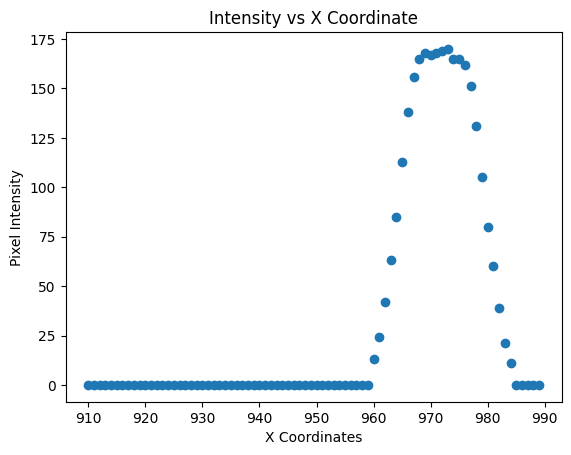

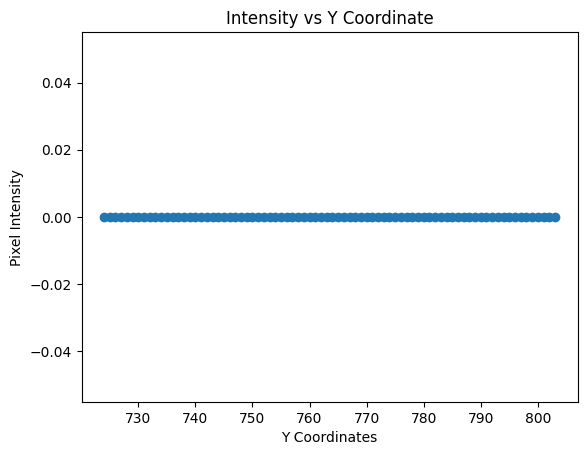

/mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/blue/128_128_128_Z_200000.bmp


ValueError: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/blue/128_128_128_Z_200000.bmp is overexposed.

In [31]:
# directory should include all images one wishes to process
directory = "/mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/"

image_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith((".jpg", ".jpeg", ".png", ".bmp"))]

# Preprocess images to filter out RGB
threshold_val = 0
for image_file in image_files:
    if threshold_val == 0:
        threshold_val = preprocess_image(image_file)
    else:
        preprocess_image(image_file, threshold_val=threshold_val)

# Read in images from corresponding directory
directory = directory + "thresholded/"
for color in ["blue"]:  # We are only filtering out red for now
    color_directory = directory + color + "/"
    x = 0
    y = 0
    image_files = [os.path.join(color_directory, file) for file in os.listdir(color_directory) if file.endswith((".jpg", ".jpeg", ".png", ".bmp"))]
    for image_file in image_files:
        print(image_file)
        image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

        # Construct scatter plot of pixel intensities
        # Get the dimensions of the image
        height, width = image.shape[:2]

        if x == 0 or y == 0:
            # Find the middle coordinates
            middle_x = width // 2
            middle_y = height // 2

            # Define the neighborhood size
            neighborhood_size = 200  # Adjust the size as needed

            # Search for a pixel with intensity > 50 in the neighborhood
            found_pixel = False
            for i in range(-neighborhood_size, neighborhood_size + 1):
                for j in range(-neighborhood_size, neighborhood_size + 1):
                    x = middle_x + i
                    y = middle_y + j

                    # Get the pixel value at the current coordinates
                    pixel_value = image[y, x]

                    # Check if the pixel intensity is greater than 50
                    if pixel_value > 50:
                        found_pixel = True
                        break

                if found_pixel:
                    break

            # Check if a suitable pixel was found
            if found_pixel:
                print("Pixel location with intensity > 50:")
                print("X:", x)
                print("Y:", y)

                # Print the center coordinates
                print("Center X:", middle_x)
                print("Center Y:", middle_y)

        plot_intensity_vs_x(image_file, x, y)
        plot_intensity_vs_y(image_file, x, y)


In [3]:
#check whether two grayscale images are identical
    
import cv2
import numpy as np

def display_nonzero_numbers(array, max_count=100):
    # Get the indices of the nonzero elements
    indices = np.nonzero(array)

    # Extract the values at the nonzero indices
    values = array[indices]

    # Display up to the specified number of nonzero values
    count = min(max_count, len(values))
    for i in range(count):
        index = tuple(idx[i] for idx in indices)
        value = values[i]
        print(f"Value at index {index}: {value}")
        
def are_images_identical(image1, image2):
    # Compare the dimensions of the images
    if image1.shape != image2.shape:
        return False

    # Compare each pixel of the images
    difference = cv2.subtract(image1, image2)
    
    # Check if all pixels are zero (indicating identical images)
    display_nonzero_numbers(difference)
    return cv2.countNonZero(difference) == 0

# Load the grayscale images
image1 = cv2.imread("32_32_32_clear_3600000.bmp", cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread("camera_32_32_32.bmp", cv2.IMREAD_GRAYSCALE)

are_images_identical(image1, image2)


1
0


In [ ]:
# try different threshold, and save these images
import cv2 
import numpy as np
import csv

# Read image in grayscale
image_path = "/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/Red32/32_32_32_clear_4000.bmp"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image = extract_middle_roi(image, 1500)

# Initialize a list to store the results
results = []

for threshold in range(5, 50):
    _, filtered_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    new_path = "/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/ThresholdExperiment/threshold=" + str(threshold) + ".bmp"
#     cv2.imwrite(new_path, filtered_image)
    
    # for each image, find the average, sd, and average + sd, and export them to a csv file
    
    # Perform calculations for black pixels
    black_mask = np.where(image < threshold, 1, 0)
    black_masked_intensities = image[black_mask == 1]
    black_mean_intensity = np.mean(black_masked_intensities)
    black_sd_intensity = np.std(black_masked_intensities)
    black_one_sd = black_mean_intensity + (1 * black_sd_intensity)
    black_two_sd = black_mean_intensity + (2 * black_sd_intensity)
    
    # Perform calculations for white pixels
    white_mask = np.where(image >= threshold, 1, 0)
    white_masked_intensities = image[white_mask == 1]
    white_mean_intensity = np.mean(white_masked_intensities)
    white_sd_intensity = np.std(white_masked_intensities)
    white_one_sd = white_mean_intensity + (1 * white_sd_intensity)
    white_two_sd = white_mean_intensity + (2 * white_sd_intensity)
    
    # Store the results in a dictionary
    result = {
        'Threshold': threshold,
        'Mean Intensity of Black Pixels': black_mean_intensity,
        'Standard Deviation of Black Pixels': black_sd_intensity,
        'Black One SD Above Average': black_one_sd,
        'Black Two SD Above Average': black_two_sd,
        'Mean Intensity of White Pixels': white_mean_intensity,
        'Standard Deviation of White Pixels': white_sd_intensity,
        'White One SD Above Average': white_one_sd,
        'White Two SD Above Average': white_two_sd
    }
    results.append(result)
    
# Define the CSV file path
csv_file_path = '/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/ThresholdExperiment/results.csv'

# Define the fieldnames for the CSV file
fieldnames = [
    'Threshold',
    'Mean Intensity of Black Pixels',
    'Standard Deviation of Black Pixels',
    'Black One SD Above Average',
    'Black Two SD Above Average',
    'Mean Intensity of White Pixels',
    'Standard Deviation of White Pixels',
    'White One SD Above Average',
    'White Two SD Above Average'
]

# Write the results to the CSV file
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for result in results:
        writer.writerow(result)


# Print a confirmation message
print("Results exported to results.csv")